# Защита персональных данных клиентов

Одной из задач проекта является обеспечение безопасности клиентских данных страховой компании. Требуется разработать метод преобразования данных, который затруднит восстановление персональной информации. Важно также обосновать правильность работы этого метода. При этом необходимо гарантировать, что защита данных не повлияет на качество моделей машинного обучения.

## Загрузка данных

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv(r'C:\Users\Barbos-Rapitos\Desktop\practicum\linear_algebra\insurance.csv')

In [44]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [45]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [46]:
data.duplicated().sum()

153

In [47]:
data.loc[data.duplicated()]

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
281,1,39.0,48100.0,1,0
488,1,24.0,32900.0,1,0
513,0,31.0,37400.0,2,0
718,1,22.0,32600.0,1,0
785,0,20.0,35800.0,0,0
...,...,...,...,...,...
4793,1,24.0,37800.0,0,0
4902,1,35.0,38700.0,1,0
4935,1,19.0,32700.0,0,0
4945,1,21.0,45800.0,0,0


In [49]:
data = data.drop_duplicates().reset_index(drop=True)

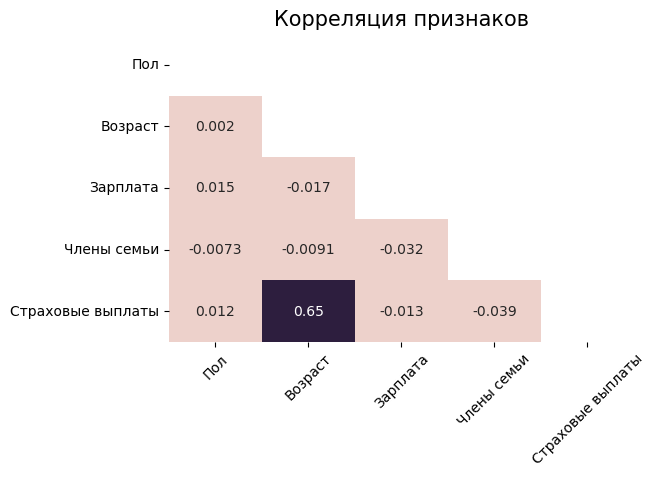

In [50]:
plt.rcParams['figure.figsize'] = (6,4)
plt.title('Корреляция признаков',fontsize=15)
# верхний треугольник корреляционной матриццы
matrix = np.triu(data.corr())

sns.heatmap(data.corr(), annot = True, cmap = sns.cubehelix_palette(8), cbar=False, mask=matrix)
plt.xticks(rotation=45);

Старховые выплаты имеют сильную корреляццию с возрастом

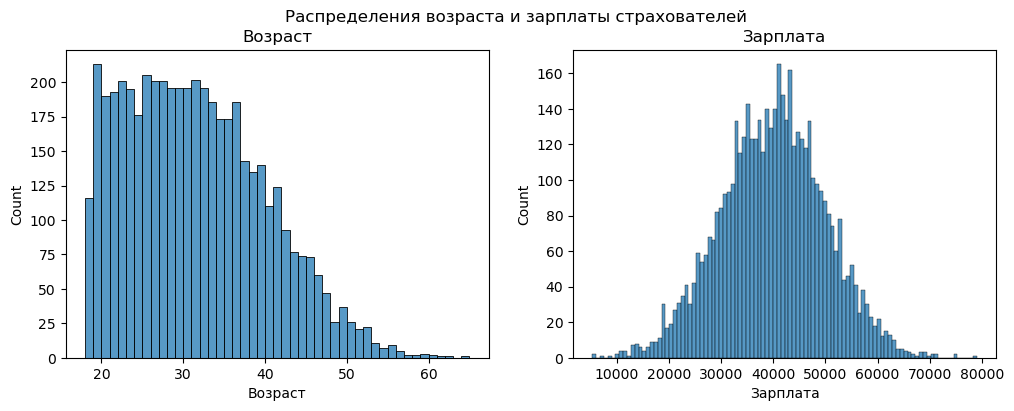

In [51]:
plt.rcParams['figure.figsize'] = (12,4)
fig, ax = plt.subplots(1,2)
sns.histplot(
            data=data['Возраст'], bins=65-18, ax=ax[0])
sns.histplot(
            data=data['Зарплата'], bins=100, ax=ax[1])
ax[0].set_title('Возраст'), ax[1].set_title('Зарплата')
plt.suptitle ('Распределения возраста и зарплаты страхователей');

Страхуют с 18 лет. Т.к старховые выплаты имеют сильную корреляццию с возрастом, страховой не выгодно страховать пожилых.

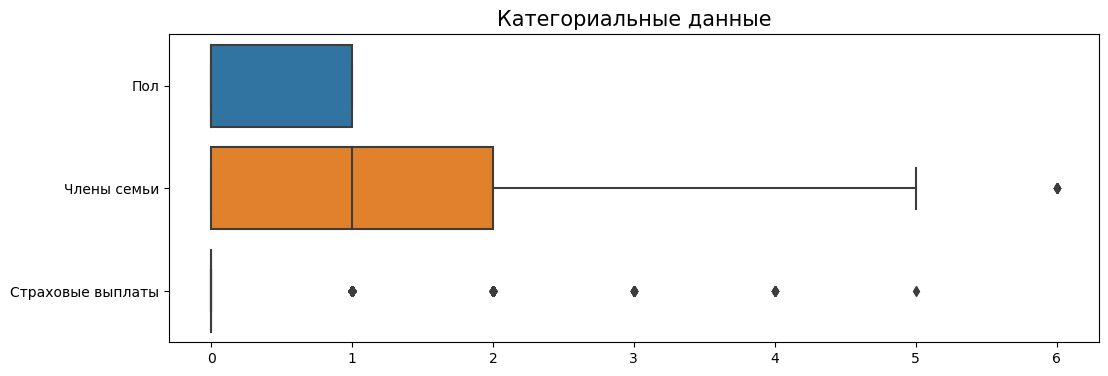

In [52]:
plt.title('Категориальные данные',fontsize=15)
sns.boxplot(
            data=data.loc[:, ~data.columns.isin(['Возраст', 'Зарплата'])], orient='h');

Медиана членов семьи 1, но так же бывает и 0, максимум 6. Медиана страховых выплат 0, максимум 5.

### Метод преобразования

Разработаем метод преобразования данных, который затруднит восстановление персональной информации. Обоснуем правильность работы этого метода. Проверим, что защита данных не повлияет на качество моделей машинного обучения.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

После домножения матрицы признаков на обратимую матрицу, качество линейной регрессии не изментится

**Обоснование:** 

Преобразуем формулу обучения 

$$
a = Xw = XEw = XPP^{-1}w = (XP)P^{-1}w = (XP)w'
$$

Преобразуем формулу предсказания 

$$
w' = ((XP)^T XP)^{-1} (XP)^T y = (P^T (X^T X) P)^{-1} (XP)^T y =P^{-1} (X^TX)^{-1}(P^T)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}X^Ty = P^{-1}w
$$

$$
a = (XP)w' = (XP)P^{-1}w = Xw
$$

После домножения матрицы признаков на обратимую матрицу, качество линейной регрессии не изментится


## Алгоритм преобразования

**Алгоритм**

* Генерируем обратимую случайную матрицу соответсвующего размера
* Умножаем на неë матрицу признаков
* Проверяем её на обратимость
* Создаём новую матрицу данных
* Ищем метрики качества на исходных данных и на преобразованных


**Обоснование**

В данном случае у нас есть 4 признака и около 5000 строк. Соответственно подходящей обратимой матрицей будет квадратная матрица четвертого порядка. При умножении на которую будет искажена информация, а качество линейной регрессии не изменится

## Проверка алгоритма

In [53]:
np.random.seed(44)
array_random = np.random.normal(3, 2.5, size=(4, 4))

Мы можем проверить правильность результата, опираясь на основное свойство обратной матрицы, т.е. np.dot(array_random, array_random_inv) = np.dot(array_random_inv, array_random) = np.eye(array_random.shape[0])
$$ 
AP = PA = E
$$

In [58]:
array_random_inv = np.linalg.inv(array_random)

In [59]:
np.allclose(np.dot(array_random, array_random_inv), np.eye(array_random.shape[0]))

True

In [60]:
np.allclose(np.dot(array_random_inv, array_random), np.eye(array_random.shape[0]))

True

Матрица обртима

In [10]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=44)

In [11]:
features_data_train = data_train.drop('Страховые выплаты', axis=1)
target_data_train = data_train['Страховые выплаты']

features_data_test = data_test.drop('Страховые выплаты', axis=1)
target_data_test = data_test['Страховые выплаты']

features_data_train.shape, target_data_train.shape, features_data_test.shape, target_data_test.shape

((3635, 4), (3635,), (1212, 4), (1212,))

In [12]:
model_before = LinearRegression()
model_before.fit(features_data_train, target_data_train)
predictions_before = model_before.predict(features_data_test)
r2_score(target_data_test, predictions_before)

0.43922159191243837

In [13]:
model_after = LinearRegression()
model_after.fit(features_data_train.values.dot(array_random), target_data_train)
predictions_after = model_after.predict(features_data_test.values.dot(array_random))
r2_score(target_data_test, predictions_after)

0.43922159191243004

#### Вывод
На основании проведенных исследований удалось вывести формулу предсказаний для линейной регрессии путем умножения признаков на случайную обратимую матрицу. Эта формула оказалась идентичной исходной до применения преобразования.

На практике было подтверждено, что качество линейной регрессии не изменяется при умножении признаков на случайную обратимую матрицу.

Если рассматривать передачу данных третьим лицам, то метод имеет ряд преимуществ. Во-первых, он значительно экономит ресурсы по сравнению с некоторыми известными алгоритмами шифрования, особенно с асимметричными алгоритмами, требующими обработки длительных ключей (например, AES и RSA), которые требуют значительных вычислительных мощностей.

Однако у подхода есть и главный недостаток: с увеличением количества признаков в выборке возрастает сложность проверки на вырожденность преобразования. В нашем случае мы смогли подобрать подходящую матрицу размером 4×4, но если количество признаков будет на порядок больше (что в теории всегда следует принять во внимание), то расчет соответствующих определителей может стать ресурсоемкой задачей. Тем не менее, и эту проблему можно будет решить, найдя подходящие алгоритмы определения определителей для больших размерностей.

В целом, данный подход к защите данных клиентов страховой компании является перспективным и эффективным, с учетом проведенных исследований и результатов, подтверждающих его работоспособность и сохранение качества моделей машинного обучения.